### Introduction to NLP Fundamentals in TensorFlow

    NLP has the goal of deriving information out of natural language (could be sequences text or speech)

    Another common term for NLP problems is sequence to sequence problems (seq2seq)

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-890aadbc-dc9a-cfdd-ce0d-dd3bdfa0ac28)


In [2]:
 ## GET helper functions
import sys
sys.path.append(r"C:\Users/wjub/01workspace/TensorFlow Developer Certificate ZTM")
import winsound
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import helper_functions

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys, calculate_results

# Get a text dataset

    The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaste or not disasterrs)

    See the original source here : https://www.kaggle.com/competitions/nlp-getting-started/data

In [3]:
helper_functions.download_file("https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip","nlp_getting_started.zip")
helper_functions.unzip_data("nlp_getting_started.zip")

## Visualizing a text data 

        To visualize our text samples, we first have to read them in, one way to do so would be to use Python :

        So another way to do this is to use pandas.

In [4]:
import pandas as pd
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle training dataframe
# frac : nb of % to shuffle 1=100%
train_df_shuffled = train_df.sample(frac=1, random_state = 42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe look like ?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class ?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total sample ?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
#  Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of  samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target:{target}", "(real diaster)" if target > 0 else "(not real diaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target:1 (real diaster)
Text:
#world Fears over missing migrants in Med: Rescuers search for survivors after a boat carrying as many a... http://t.co/6DS67XAI5e #news

---

Target:0 (not real diaster)
Text:
So derailed_benchmark is cool for paths. i wonder if i can run it to find leaks in Jobs given to  resque  too?

---

Target:0 (not real diaster)
Text:
New Ladies Shoulder Tote Handbag Women Cross Body Bag Faux Leather Fashion Purse - Full reÛ_ http://t.co/y87Gi3BRlV http://t.co/1zbhVDCXzS

---

Target:1 (real diaster)
Text:
@Raishimi33 :) well I think that sounds like a fine plan where little derailment is possible so I applaud you :)

---

Target:1 (real diaster)
Text:
'Invading Iraq was a catastrophic mistake'.

Diplomacy needs to replace constant threat of war by US and Israel:

http://t.co/yqjpn3qUUX

---



### Split data into training and validation sets

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# turn dataframe values to dataframe columns
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                    train_df_shuffled["target"].to_numpy(),
                                                    test_size = 0.1, # use 10% of traianing data for validations
                                                    random_state = 42)

In [12]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# # Reshape data
# train_sentences = train_sentences.reshape(-1, 1)
# train_labels = train_labels.reshape(-1, 1)
# val_labels = val_labels.reshape(-1, 1)
# val_sentences = val_sentences.reshape(-1, 1)
# train_sentences.shape, train_labels.shape, val_labels.shape, val_sentences.shape

In [14]:
# check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

    When dealing with a text problem, on of the first things you'll have to do before you can build a model is to convert your text to numbers.

    There are a few ways to do this, namely:
     * Tokenization - direct mapping of token (a token could be a word or a caracter) to number
     * Embedding - create a matric of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

# Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorization = TextVectorization(max_tokens=50000, # how many words in the vocabulary(utomatically add <OOV>)
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None, # Create groups of n-words?
                                       output_mode="int", # How to map tokens to numbers
                                       output_sequence_length=None, # how longdo you want your sequences to be?
                                       pad_to_max_tokens=True)

In [17]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [18]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])) # nb of words
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # average for 1 sentence

15

In [19]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be 

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                   output_mode = "int",
                                   output_sequence_length= max_length)

In [20]:
# Fit the text vectorizer  to the training text 
# that convert our words data to numeric format 
text_vectorizer.adapt(train_sentences)

In [21]:
# Create a sample sentences and tokenize it 
sample_sentence = "There's a flood in my street !"
text_vectorizer([sample_sentence])


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [22]:
# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
print(f"Origina text:\n{random_sentence}\
\n\n Vectorized version:")
text_vectorizer([random_sentence])

Origina text:
Heat wave warning aa? Ayyo dei. Just when I plan to visit friends after a year.

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 288,  472,  338, 6288,    1,    1,   29,   45,    8,  241,    5,
        1742,  819,   43,    3]], dtype=int64)>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


## Creating an Embedding using an Embedding Layer

    To make our embedding, we re going to use TensorFlow's embedding layer : https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
    The parameters we xare most about for our embedding layer:
    *`input_dim` = the size of our vocabulary
    *`output_dim` = the size of the output embedding vector, for example, a value of 100 could mean each token gets represented by a vector 100 long
    * `input_length` = length of the sequences being passed to the embedding layer

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)
embedding

In [25]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
\n\n Embedded version :")
# Embed the random sentence (turn it into danse victors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))

#sample_embed = tf.reshape(sample_embed, (1, 15, 128))
sample_embed

Original text:
On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N

 Embedded version :


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01259222, -0.02260396, -0.0282679 , ...,  0.04498501,
          0.02527041, -0.01866557],
        [-0.01667808, -0.00251348, -0.02155714, ..., -0.01808948,
          0.02658334, -0.01193937],
        [-0.03097551,  0.00069269,  0.01390311, ...,  0.00333037,
         -0.04288533,  0.02857199],
        ...,
        [ 0.00043489,  0.00190035,  0.03748127, ..., -0.01719388,
         -0.01603042,  0.03695795],
        [ 0.02399388, -0.02582198,  0.03950289, ..., -0.03432311,
          0.04686573, -0.04798753],
        [ 0.02399388, -0.02582198,  0.03950289, ..., -0.03432311,
          0.04686573, -0.04798753]]], dtype=float32)>

In [26]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.01259222, -0.02260396, -0.0282679 , -0.03223418,  0.04039583,
         0.02806241,  0.04105767, -0.03088768, -0.0354462 , -0.02834523,
         0.00583463,  0.03161821,  0.03396672, -0.00025386, -0.01558875,
         0.02176858,  0.03669307,  0.04534841,  0.04414603, -0.04898053,
         0.02281863, -0.00730277,  0.03802624,  0.04732194,  0.00593974,
        -0.03590279,  0.0247716 , -0.03921125, -0.02366066,  0.02042564,
        -0.00260689,  0.00564516, -0.01286004,  0.03689345, -0.00501659,
         0.04730035,  0.0093969 ,  0.04789838, -0.01875985,  0.04328075,
        -0.01055817, -0.02215543,  0.03457144, -0.03274769, -0.02053611,
         0.0211804 ,  0.00405381,  0.00225909, -0.00845448, -0.01188415,
        -0.01069843,  0.03529857, -0.04431583, -0.00214104,  0.01066195,
         0.0233484 , -0.01993728, -0.0200797 , -0.03995167,  0.033649  ,
         0.03745433,  0.01288137, -0.04712002, -0.04351516,  0.01703963,
  

## Modelling a text dateset (running a series of experimente)

    Now we ve a got way to turn our text sequences into numbers,
    it's time to start building a series of modelling experiments.

    We'll start with a baseline and moce on from there.

* Model 0: Naive Bayes (baseline) with sklearn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (danse model)
* Model 2 : LSTM model (RNN)
* model 3 : GRU model (RNN)
* model 4 : Bidirectional-LSTM model (RNN)
* Model 5 : 1D Convolutional Neural Network (CNN)
* Model 6 : TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7 : Same as model 6 with 10% of training data

How are we going to approch all of these ?

Use the standard steps in modelling with tensorflow:

* Create a model 
* Build a model
* Fit a model
* Evaluate model

### Model 0 : Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you're got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayers using the TF-IDF formula to convert our words to numbers

>** note : ** it's common practice to use non-Deep Learning Algorithms as a baseline because of their speed and then later using Deep Learning to to see if you can imporove upon them.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline ([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text clf : juste classification
])

# Fit the pipleine to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achives an accuracy of : {baseline_score}")

Our baseline model achives an accuracy of : 0.7926509186351706


In [29]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]
# for i in range(0,10,1):
#     print(f" {val_sentences[i]} \n prediction : {baseline_preds[i]}")
    

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however this will be cumbersome and could easily be fixed with function

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy.
* Precision.
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the sklearn

### 

In [30]:
# Function to evaluate : accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# rajouter
def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional string
x = text_vectorizer(inputs)# turn the input text into numbers
x = embedding(x) # transform the input numbers in embedding
x = layers.GlobalAveragePooling1D()(x) # Condense the feature vector for each token to on vector
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs
model_1 = tf.keras.Model(inputs,outputs, name="Model_1_dense")

In [34]:
model_1.summary()    

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [35]:
model_1.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [36]:
history_model_1 = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                        experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20230116-222018
Epoch 1/5
215/215 [==============================] - 4s 6ms/step - loss: 0.6115 - accuracy: 0.6989 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.4414 - accuracy: 0.8173 - val_loss: 0.4702 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3464 - accuracy: 0.8599 - val_loss: 0.4568 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2837 - accuracy: 0.8936 - val_loss: 0.4651 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2369 - accuracy: 0.9118 - val_loss: 0.4827 - val_accuracy: 0.7835


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4827 - accuracy: 0.7835


[0.482700377702713, 0.7834645509719849]

In [38]:
# Make some predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape, model_1_pred_probs[0]

24/24 [==============================] - 0s 2ms/step


((762, 1), array([0.40546677], dtype=float32))

In [39]:
# Look at a single prediction
model_1_pred_probs[:10]

array([[0.40546677],
       [0.8031199 ],
       [0.9978848 ],
       [0.13206421],
       [0.11119317],
       [0.9426388 ],
       [0.9129343 ],
       [0.9939521 ],
       [0.9678228 ],
       [0.2901585 ]], dtype=float32)

In [40]:
model_1_pred_probs.shape

(762, 1)

In [41]:
# Convert model prediction probabilities to label format

model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                   y_pred=model_1_pred_probs)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 0.7880043492637875,
 'recall': 0.7834645669291339,
 'f1': 0.7804929895574078}

In [43]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [44]:
# compare witch best between our models
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values())) 

array([False, False, False, False])

## Visualizing learned embeddings


In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
max_vocab_length

10000

In [47]:
# Model 1 summary
model_1.summary()

Model: "Model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [51]:
# Get the weight matrix of embedding layer
# (thse are the numerical representations of each token in our training data, which have been learned for -5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()
print(embed_weights[0].shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


In [52]:
embed_weights

[array([[ 0.03820484, -0.01344948,  0.02937469, ..., -0.04787105,
          0.04021944, -0.06293101],
        [ 0.00721968,  0.00771107,  0.03239628, ..., -0.02388553,
         -0.01896044,  0.02937855],
        [ 0.00973042,  0.05472668,  0.00695324, ..., -0.02302973,
          0.01827305,  0.01544901],
        ...,
        [ 0.02152051, -0.03912783,  0.0219495 , ..., -0.03770596,
         -0.01462867, -0.02694877],
        [-0.00443885,  0.07291612,  0.00105182, ..., -0.00767418,
         -0.02795472,  0.00116968],
        [ 0.0764626 ,  0.03179592, -0.05615811, ..., -0.06207443,
         -0.0646542 , -0.05228703]], dtype=float32)]

Now we've got the embedding matric our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handly tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves
https://www.tensorflow.org/text/guide/word_embeddings

In [53]:
# # Create embedding files (we got this from TensorFlow's word embedding documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[0][index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [54]:
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

Downloading the files above can visualize them usign http://projector.tensorflow.org/ and clicking the "load" button on the left hand
*Ressources : if you'd like to know more about embedding, I'd encourage you to check out :
- Jay Alammer's vusualized word2vec post : https://jalammar.github.io/illustrated-word2vec/
- TensorFlow's Word Embeddings guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later
* Ressources :> 
If you want an overview of the internale of a recurrent neural network, see the following : 
    - MIT's sequence modelling lecture https://www.youtube.com/watch?v=QvkQ1B3FBqA
    - Chris Olah's intro to LSTMs : https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    - Andrej Karphathy's the unreasonable effectiveness of recurrent neural network : http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    - https://www.youtube.com/watch?v=QvkQ1B3FBqA&t=166s

### Model 2 : LSTM 
LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN Typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense) -> Output (label probability)
```

In [55]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to  returns sequences=True
# print(x.shape)
x = layers.LSTM(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
# print(x.shape)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")


In [56]:
# Get the summary 
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [57]:
# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# Fit the model 
history_model2 = model_2.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                   experiment_name="model_2_LSTM")]) 

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230116-222130
Epoch 1/5
215/215 [==============================] - 12s 49ms/step - loss: 0.2545 - accuracy: 0.9053 - val_loss: 0.6648 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 11s 49ms/step - loss: 0.1705 - accuracy: 0.9356 - val_loss: 0.8671 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 10s 48ms/step - loss: 0.1333 - accuracy: 0.9473 - val_loss: 0.9047 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 10s 48ms/step - loss: 0.1083 - accuracy: 0.9575 - val_loss: 0.8564 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 10s 48ms/step - loss: 0.0892 - accuracy: 0.9670 - val_loss: 1.1356 - val_accuracy: 0.7677


In [59]:
# Make prediction with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 7ms/step


array([[7.9303145e-02],
       [8.9158654e-01],
       [1.0000000e+00],
       [4.1239511e-02],
       [1.1321775e-04],
       [1.0000000e+00],
       [7.7143604e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [6.4978713e-01]], dtype=float32)

In [60]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs)) # enlever les dimension en plus
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 76.77165354330708,
 'precision': 0.7679905783589133,
 'recall': 0.7677165354330708,
 'f1': 0.7663871505080737}

In [62]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [63]:
np.array(list(model_1_results.values())) > np.array(list(model_2_results.values()))  

array([ True,  True,  True,  True])

### Model 3 : GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [64]:
# Build an RNN GRU
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.GRU(3)(x)
# x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) 
# x = tf.keras.layers.LSTM(42, return_sequences=True)(x)
# x = tf.keras.layers.GRU(units=92, return_sequences=True)(x)

# # Apply global average pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# x = tf.keras.layers.Dense(64, activation="relu")(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [65]:
# # Version 2
# # Build an RNN GRU
# inputs = tf.keras.layers.Input(shape=(1), dtype=tf.string)
# x = text_vectorizer(inputs)
# x = embedding(x)
# # x = tf.keras.layers.GRU(64)(x)
# x = tf.keras.layers.GRU(units=64, return_sequences=True)(x) 
# x = tf.keras.layers.LSTM(42, return_sequences=True)(x)
# x = tf.keras.layers.GRU(units=92, return_sequences=True)(x)

# # Apply global average pooling
# x = tf.keras.layers.GlobalAveragePooling1D()(x)

# x = tf.keras.layers.Dense(64, activation="relu")(x)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [66]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 3)                 1197      
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 1,281,201
Trainable params: 1,281,201
Non-trainable params: 0
_____________________________________________

In [67]:
# compile the model
model_3.compile(loss="binary_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [68]:
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences,val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                        experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230116-222224
Epoch 1/5
215/215 [==============================] - 5s 11ms/step - loss: 0.5226 - accuracy: 0.7714 - val_loss: 0.4991 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2452 - accuracy: 0.9340 - val_loss: 0.4797 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1511 - accuracy: 0.9628 - val_loss: 0.5379 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1146 - accuracy: 0.9718 - val_loss: 0.5647 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0959 - accuracy: 0.9749 - val_loss: 0.6120 - val_accuracy: 0.7782


In [69]:
# Make som prediction with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)

24/24 [==============================] - 0s 3ms/step


In [70]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [71]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.82152230971128,
 'precision': 0.7804499491198106,
 'recall': 0.7782152230971129,
 'f1': 0.7760126933653841}

In [72]:
# comparing model 1 with model 2
np.array(list(model_1_results.values())) > np.array(list(model_3_results.values()))  

array([ True,  True,  True,  True])

# Mode 4 :  Bidirectional RNN



In [73]:
# create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation="relu"))(x)
# x = tf.keras.layers.AveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_layer")

In [74]:
model_4.summary()

Model: "model_4_Bidirectional_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable param

In [75]:
model_4_predict_prob = tf.squeeze(model_4.predict(val_sentences))
model_4_preds = tf.round(model_4_predict_prob)

24/24 [==============================] - 1s 11ms/step


In [76]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 28.21522309711286,
 'precision': 0.28573041411174227,
 'recall': 0.2821522309711286,
 'f1': 0.2808821854759865}

# Model 4 : Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence), however, bidirectional RNN goes from right to left as well as left to right.



In [77]:
# Build a bidirectional RNN in TensorFlow 
# create the model
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64))(x)
print(x.shape) # nb_units * 2 comme c'est bidirectional

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional_layer")

(None, 128)


In [78]:
 # Get a summary 
model_4.summary()

Model: "model_4_Bidirectional_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                       

In [79]:
# Compile the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [80]:
history_model_4 = model_4.fit(train_sentences,
                             train_labels,
                             epochs=5,
                             validation_data=(val_sentences, val_labels),
                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="Bidirectionalmod")])

Saving TensorBoard log files to: model_logs/Bidirectionalmod/20230116-222239
Epoch 1/5
215/215 [==============================] - 10s 23ms/step - loss: 0.1210 - accuracy: 0.9612 - val_loss: 0.7434 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0789 - accuracy: 0.9704 - val_loss: 0.8741 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0662 - accuracy: 0.9736 - val_loss: 0.9137 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0594 - accuracy: 0.9750 - val_loss: 0.8923 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0514 - accuracy: 0.9799 - val_loss: 1.2683 - val_accuracy: 0.7717


In [81]:
# Make prediction with our bidirectional model
model_4_predict_prob = tf.squeeze(model_4.predict(val_sentences))
# Convert pred probs to labels 
model_4_preds = tf.round(model_4_predict_prob)

24/24 [==============================] - 1s 6ms/step


In [82]:
# Convert pred probs to labels 
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.16535433070865,
 'precision': 0.7722289521502119,
 'recall': 0.7716535433070866,
 'f1': 0.7701831305177762}

## Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (geight x width)... however, our text data is 1D.

Previously we've Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typicallyConv1D + Pooling layer) -> Pooling -> Outputs (class probabilities) 

## Model 5 : Conv1D

For different explanations of parameters see:
* https://poloclub.github.io/cnn-explainer/
* Difference between "same" and "valid" padding:https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t#:~:text=To%20sum%20up%2C%20'valid',same'%20padding%20means%20using%20padding.

In [83]:
# embedding_test = embedding(text_vectorizer(["c est test de phrase"]))
# conv_1d = tf.keras.layers.Conv1D(filters=32,
#                                  kernel_size=5 , 
#                                  activation="relu",
#                                  padding="valid")
# conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
# max_pool = tf.keras.layers.GlobalAvgPool1D()
# max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

# embedding_test.shape, conv_1d_output.shape, max_pool_output.shape
# # embedding_test
# # conv_1d_output
# # max_pool_output

In [84]:
# Test out our embedding layer, Conv1D layer and max pooling
inputs = tf.keras.layers.Input(shape=(1), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters=64,
                           kernel_size=5 , 
                           activation="relu",
                           strides=1,
                           padding="valid")(x)
x = tf.keras.layers.GlobalAvgPool1D()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1d")

In [85]:
model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)              

In [86]:
model_5.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                 experiment_name="model_5_Conv1d")])

Saving TensorBoard log files to: model_logs/model_5_Conv1d/20230116-222305
Epoch 1/5
215/215 [==============================] - 6s 8ms/step - loss: 0.1685 - accuracy: 0.9350 - val_loss: 0.7964 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1007 - accuracy: 0.9577 - val_loss: 0.8963 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0807 - accuracy: 0.9680 - val_loss: 1.0285 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0682 - accuracy: 0.9708 - val_loss: 1.1343 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0606 - accuracy: 0.9731 - val_loss: 1.2970 - val_accuracy: 0.7612


In [87]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs
# convert model_5_pred_probs to labels 0 or 1
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
# model_5_preds

24/24 [==============================] - 0s 2ms/step


In [88]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'precision': 0.7622953452640989,
 'recall': 0.7611548556430446,
 'f1': 0.7591215732608759}

In [89]:
# Check witch the best 
np.array(list(model_5_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

# Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder : https://tfhub.dev/google/universal-sentence-encoder/4

https://colab.research.google.com/drive/1tjnmiNUxxR090bVcze1jD_J4svhPPy_W#scrollTo=XC37Wot1Fw74

In [90]:
model_6_results = {'accuracy': 81.62729658792651,
                   'precision': 0.8162262387656088,
                   'recall': 0.8162729658792651,
                   'f1': 0.8157886543602123}
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8162262387656088,
 'recall': 0.8162729658792651,
 'f1': 0.8157886543602123}

# Model 7: TF Hub Pretrained USE but with 10% of training data 

Transfer learning really helps when you don't have a large dataset.

To see how our modeel performs on a smaller dataset, let's replicate `model _6` except we'll train it on 10% of data. 

In [91]:
model_7_results = {'accuracy': 77.55905511811024,
                   'precision': 0.7765218346613636,
                   'recall': 0.7755905511811023,
                   'f1': 0.7739772681043204}
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7765218346613636,
 'recall': 0.7755905511811023,
 'f1': 0.7739772681043204}

    **Note : ** Be *very* careful when creating training/val/test split that you d'ont leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.  

## Comparing the performance of each of our models

In [92]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                "1_simple_dense": model_1_results,
                                "2_lstm":model_2_results,
                                "3_gru":model_3_results,
                                "4_bidirectional": model_4_results,
                                "5_conv1d": model_5_results,
                                "6_tf_hub_use_encoder": model_6_results,
                                "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [93]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.788004,0.783465,0.780493
2_lstm,0.767717,0.767991,0.767717,0.766387
3_gru,0.778215,0.780450,0.778215,0.776013
4_bidirectional,0.771654,0.772229,0.771654,0.770183
5_conv1d,0.761155,0.762295,0.761155,0.759122
6_tf_hub_use_encoder,0.816273,0.816226,0.816273,0.815789
7_tf_hub_use_encoder_10_percent,0.775591,0.776522,0.775591,0.773977


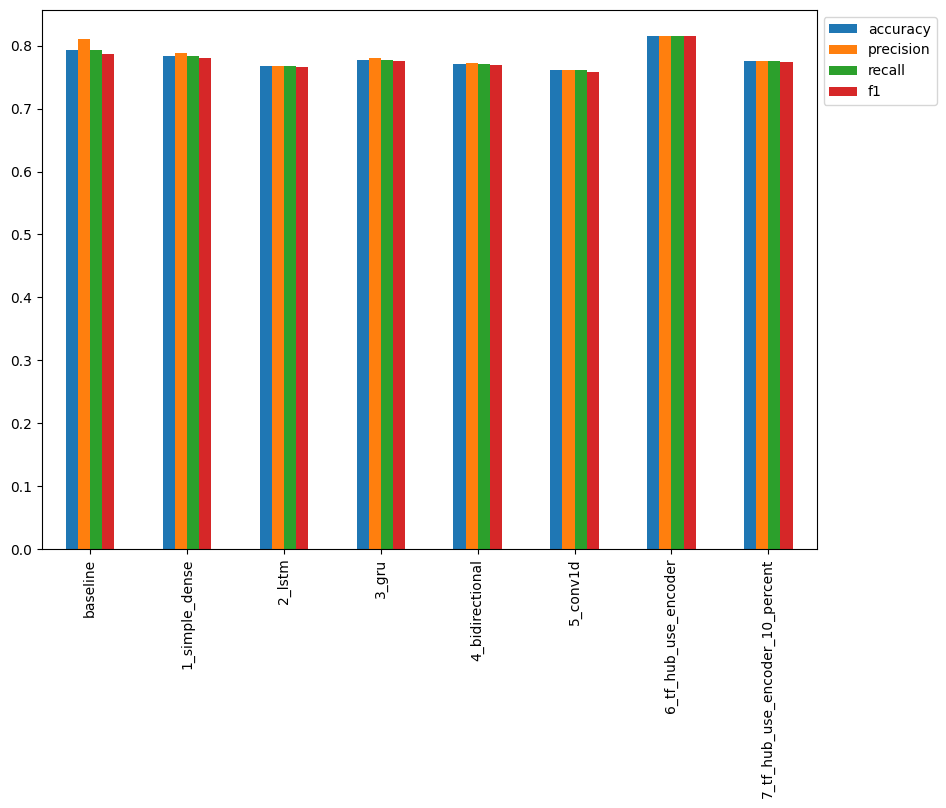

In [94]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

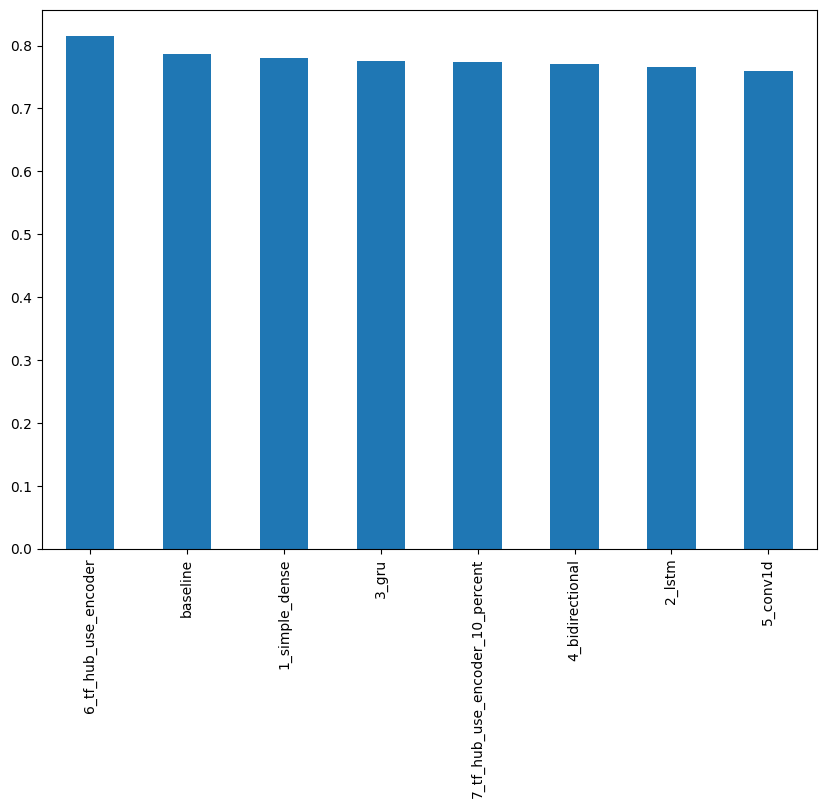

In [95]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Uploading our modeel training logs to TensorBoard.dev
we can further inspect our model's performance using tensorboard.dev : https://tensorboard.dev/

In [96]:
# !tensorboard dev upload --logdir ./model_logs/

In [97]:
# !pip install tensorboard==2.11
#!pip uninstall flatbuffers
#!pip uninstall -y tensorboard

In [99]:
# !tensorboard dev upload --logdir ./model_logs/ \
#  --name "7 models experiment" \
#  --description "Training results from http://localhost:8888/notebooks/01workspace/TensorFlow%20Developer%20Certificate%20ZTM/partie_2/TensorFlow_Developer_Certificate_ZTM/08_introduction_to_nlp_in_tensorflow/08_introduction_to_nlp_in_tf.ipynb" \
#  --one_shot

### Load model already saved 

In [101]:
model_6 = tf.keras.models.load_model("save_models/model_6.H5")

In [107]:
model_4 = tf.keras.models.load_model("save_models/model_4.H5")

In [104]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [109]:
model_4.evaluate(val_sentences,val_labels)

UnknownError: Graph execution error:

JIT compilation failed.
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/embedding_lookup/mod}}]] [Op:__inference_test_function_86051]